### **Installing Libraries and Importing Modules:**

In [3]:
import shap
import interpret

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2

import warnings
from sklearn.exceptions import ConvergenceWarning

from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectPercentile

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn import svm

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

### **Function Declarations:**

In [4]:
def load_data(file_name):
  df = pd.read_csv(file_name,encoding='utf-8', engine='python')
  return df

def plot_label_distribution(y, title):
  counts = y.value_counts()
  plt.figure(figsize=(8, 9))
  plt.bar(counts.index, counts.values, tick_label=['benign', 'phishing'], color=['#4477AA', '#EE6677'])
  plt.xlabel('Label')
  plt.ylabel('Count')
  plt.title(title)
  plt.show()

def plot_corr_matrix(X):
  corr_matrix = X.corr()
  plt.figure(figsize=(50, 50))
  mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
  sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', mask=mask, annot_kws={"size": 8})
  plt.show()

def print_correlated_pairs(X):
  corr_matrix = X.corr()
  corr_pairs = corr_matrix.unstack()
  selected_pairs = corr_pairs[((corr_pairs > 0.5) | (corr_pairs < -0.5)) & (corr_pairs != 1)]
  sorted_pairs = selected_pairs.sort_values(kind="quicksort")
  pd.set_option('display.max_rows', None)
  print(sorted_pairs)

def find_correlated_features(dataset, threshold):
  col_corr = set()  # Set of all the names of correlated columns
  corr_matrix = dataset.corr()
  for i in range(len(corr_matrix.columns)):
    for j in range(i):
      if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
        colname = corr_matrix.columns[i]  # getting the name of column
        col_corr.add(colname)
  return col_corr

def drop_correlated_features(X_train, X_test, corr_features):
  X_train = X_train.drop(corr_features,axis=1)
  X_test = X_test.drop(corr_features,axis=1)
  return X_train, X_test

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
  # Train the model
  model.fit(X_train, y_train)

  # Make predictions on the test set
  y_pred = model.predict(X_test)

  # Calculate the evaluation metrics
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)

  # Print the evaluation metrics
  print(f"{model_name}:")
  print(f"Accuracy: {accuracy}")
  print(f"Precision: {precision}")
  print(f"Recall: {recall}")
  print(f"F1 Score: {f1}\n")

  # Return the evaluation metrics
  return [accuracy, precision, recall, f1]

def plot_metrics(models_metrics, metric_names, model_names, graph_title):
  n_models = len(model_names)
  n_metrics = len(metric_names)
  bar_width = 0.15
  r = np.arange(n_models)

  # Define colors for each metric
  colors = ['#4477AA', '#228833', '#CCBB44', '#EE6677']

  # Increase the figure size to make the graph wider
  fig, ax = plt.subplots(figsize=(18, 6))

  for i in range(n_metrics):
    # Convert metrics from range 0-1 to 0-100
    metrics_percentage = [metric * 100 for metric in [metrics[i] for metrics in models_metrics]]
    # Add a small gap between the bars in each grouping by subtracting a small value from the bar width
    rects = ax.bar(r + i * (bar_width + 0.02), metrics_percentage, width=bar_width, label=metric_names[i], color=colors[i])

    # Add data labels on top of each bar
    for rect in rects:
      height = rect.get_height()
      ax.text(rect.get_x() + rect.get_width() / 2., 1.02 * height,
              '%.2f' % float(height),
              ha='center', va='bottom')

  ax.set_xlabel('Models')
  ax.set_ylabel('Scores')  # Update label to indicate percentage
  ax.set_title(graph_title)
  ax.set_xticks(r + (n_metrics / 2 - 0.5) * (bar_width + 0.02))
  ax.set_xticklabels(model_names)
  # Move the legend to the bottom
  ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)

  plt.show()

### **Load Datasets:**

**Loading Preprocessed & Presplit Data**

In [9]:
df1_train_over = load_data('../Dataset/Training/Dataset1/Oversampled/70_30_train.csv')

In [10]:
df1_train_over.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81228 entries, 0 to 81227
Data columns (total 99 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   qty_dot_url                 81228 non-null  int64  
 1   qty_hyphen_url              81228 non-null  int64  
 2   qty_underline_url           81228 non-null  int64  
 3   qty_slash_url               81228 non-null  int64  
 4   qty_questionmark_url        81228 non-null  int64  
 5   qty_equal_url               81228 non-null  int64  
 6   qty_at_url                  81228 non-null  int64  
 7   qty_and_url                 81228 non-null  int64  
 8   qty_exclamation_url         81228 non-null  int64  
 9   qty_space_url               81228 non-null  int64  
 10  qty_tilde_url               81228 non-null  int64  
 11  qty_comma_url               81228 non-null  int64  
 12  qty_plus_url                81228 non-null  int64  
 13  qty_asterisk_url            812

In [12]:
df1_train_under = load_data('../Dataset/Training/Dataset1/Undersampled/70_30_train.csv')

In [13]:
df1_train_under.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42876 entries, 0 to 42875
Data columns (total 99 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   qty_dot_url                 42876 non-null  int64  
 1   qty_hyphen_url              42876 non-null  int64  
 2   qty_underline_url           42876 non-null  int64  
 3   qty_slash_url               42876 non-null  int64  
 4   qty_questionmark_url        42876 non-null  int64  
 5   qty_equal_url               42876 non-null  int64  
 6   qty_at_url                  42876 non-null  int64  
 7   qty_and_url                 42876 non-null  int64  
 8   qty_exclamation_url         42876 non-null  int64  
 9   qty_space_url               42876 non-null  int64  
 10  qty_tilde_url               42876 non-null  int64  
 11  qty_comma_url               42876 non-null  int64  
 12  qty_plus_url                42876 non-null  int64  
 13  qty_asterisk_url            428

In [14]:
df1_train_overunder = load_data('../Dataset/Training/Dataset1/Over_Undersampled/70_30_train.csv')

In [15]:
df1_train_overunder.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65579 entries, 0 to 65578
Data columns (total 99 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   qty_dot_url                 65579 non-null  int64  
 1   qty_hyphen_url              65579 non-null  int64  
 2   qty_underline_url           65579 non-null  int64  
 3   qty_slash_url               65579 non-null  int64  
 4   qty_questionmark_url        65579 non-null  int64  
 5   qty_equal_url               65579 non-null  int64  
 6   qty_at_url                  65579 non-null  int64  
 7   qty_and_url                 65579 non-null  int64  
 8   qty_exclamation_url         65579 non-null  int64  
 9   qty_space_url               65579 non-null  int64  
 10  qty_tilde_url               65579 non-null  int64  
 11  qty_comma_url               65579 non-null  int64  
 12  qty_plus_url                65579 non-null  int64  
 13  qty_asterisk_url            655

In [16]:
df1_test = load_data('../Dataset/Testing/Dataset1/70_30_test.csv')

In [17]:
df1_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26595 entries, 0 to 26594
Data columns (total 99 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   qty_dot_url                 26595 non-null  int64  
 1   qty_hyphen_url              26595 non-null  int64  
 2   qty_underline_url           26595 non-null  int64  
 3   qty_slash_url               26595 non-null  int64  
 4   qty_questionmark_url        26595 non-null  int64  
 5   qty_equal_url               26595 non-null  int64  
 6   qty_at_url                  26595 non-null  int64  
 7   qty_and_url                 26595 non-null  int64  
 8   qty_exclamation_url         26595 non-null  int64  
 9   qty_space_url               26595 non-null  int64  
 10  qty_tilde_url               26595 non-null  int64  
 11  qty_comma_url               26595 non-null  int64  
 12  qty_plus_url                26595 non-null  int64  
 13  qty_asterisk_url            265

In [18]:
df2_train = load_data('../Dataset/Training/Dataset2/70_30_train.csv')

In [19]:
df2_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13601 entries, 0 to 13600
Data columns (total 80 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   url_length                  13601 non-null  int64  
 1   hostname_length             13601 non-null  int64  
 2   ip                          13601 non-null  int64  
 3   total_of.                   13601 non-null  int64  
 4   total_of-                   13601 non-null  int64  
 5   total_of@                   13601 non-null  int64  
 6   total_of?                   13601 non-null  int64  
 7   total_of&                   13601 non-null  int64  
 8   total_of=                   13601 non-null  int64  
 9   total_of_                   13601 non-null  int64  
 10  total_of~                   13601 non-null  int64  
 11  total_of%                   13601 non-null  int64  
 12  total_of/                   13601 non-null  int64  
 13  total_of*                   136

In [21]:
df2_test = load_data('../Dataset/Testing/Dataset2/70_30_test.csv')

In [22]:
df2_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5830 entries, 0 to 5829
Data columns (total 80 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   url_length                  5830 non-null   int64  
 1   hostname_length             5830 non-null   int64  
 2   ip                          5830 non-null   int64  
 3   total_of.                   5830 non-null   int64  
 4   total_of-                   5830 non-null   int64  
 5   total_of@                   5830 non-null   int64  
 6   total_of?                   5830 non-null   int64  
 7   total_of&                   5830 non-null   int64  
 8   total_of=                   5830 non-null   int64  
 9   total_of_                   5830 non-null   int64  
 10  total_of~                   5830 non-null   int64  
 11  total_of%                   5830 non-null   int64  
 12  total_of/                   5830 non-null   int64  
 13  total_of*                   5830 

### **Feature and Label Definition:**

**Define Training Dataset-1 (SMOTE Oversampling)**

In [ ]:
# Define the target variable for the training set
y_train_1_over = df1_train_over['phishing']

# Drop the target variable for the training set
X_train_1_over = df1_train_over.drop(labels=['phishing'], axis=1)

**Define Balanced Training Dataset-1 (SMOTE Oversampling)**

In [ ]:
# Separate benign and phishing instances in Dataset 1
df1_train_over_benign = df1_train_over[df1_train_over['phishing'] == 0]
df1_train_over_phishing = df1_train_over[df1_train_over['phishing'] == 1]

# Get the number of benign and phishing instances in Dataset 2
num_benign = len(df2_train[df2_train['status'] == 0])
num_phishing = len(df2_train[df2_train['status'] == 1])

# Randomly sample benign and phishing instances from Dataset 1 to match the number of benign and phishing instances in Dataset 2
df1_train_over_benign_sampled = df1_train_over_benign.sample(n=num_benign, random_state=42)
df1_train_over_phishing_sampled = df1_train_over_phishing.sample(n=num_phishing, random_state=42)

# Combine the sampled benign and phishing instances
df1_train_over_sampled = pd.concat([df1_train_over_benign_sampled, df1_train_over_phishing_sampled])

# Display new class counts
print(df1_train_over_sampled.phishing.value_counts())

# Define the target variable for the sampled training set
y_train_1_over_sampled = df1_train_over_sampled['phishing']

# Drop the target variable for the sampled training set
X_train_1_over_sampled = df1_train_over_sampled.drop(labels=['phishing'], axis=1)

phishing
0    6831
1    6770
Name: count, dtype: int64


**Define Training Dataset-1 (RandomUnderSampler Undersampling)**

In [ ]:
# Define the target variable for the training set
y_train_1_under = df1_train_under['phishing']

# Drop the target variable for the training set
X_train_1_under = df1_train_under.drop(labels=['phishing'], axis=1)

**Define Training Dataset-1 (SMOTEENN Over-Undersampling)**

In [ ]:
# Define the target variable for the training set
y_train_1_overunder = df1_train_overunder['phishing']

# Drop the target variable for the training set
X_train_1_overunder = df1_train_overunder.drop(labels=['phishing'], axis=1)

**Define Testing Dataset-1**

In [ ]:
# # Define the target variable for the testing set
# y_test_1 = df1_test['phishing']

# # Drop the target variable for the testing set
# X_test_1 = df1_test.drop(labels=['phishing'], axis=1)

**Define Balanced Testing Dataset-1**

In [ ]:
# Calculate the number of instances in the minority class
minority_class_count = len(df1_test[df1_test.phishing==1])

# Sample the majority class to match the number of samples in the minority class
df1_test_majority_sampled = df1_test[df1_test.phishing==0].sample(n=minority_class_count, random_state=42)

# Combine minority class with sampled majority class
df1_test_balanced = pd.concat([df1_test_majority_sampled, df1_test[df1_test.phishing==1]])

# Display new class counts
print(df1_test_balanced.phishing.value_counts())

# Now you can define your test set with the balanced data
y_test_1 = df1_test_balanced['phishing']
X_test_1 = df1_test_balanced.drop(labels=['phishing'], axis=1)

phishing
0    9209
1    9209
Name: count, dtype: int64


**Define Training Dataset-2**

In [ ]:
# Define the target variable for the training set
y_train_2 = df2_train['status']

# Drop the target variable for the training set
X_train_2 = df2_train.drop(labels=['status'], axis=1)

**Define Testing Dataset-2**

In [ ]:
# Define the target variable for the testing set
y_test_2 = df2_test['status']

# Drop the target variable for the testing set
X_test_2 = df2_test.drop(labels=['status'], axis=1)

### **Label Visualization:**

**Graph Benign/Phishing Distribution**

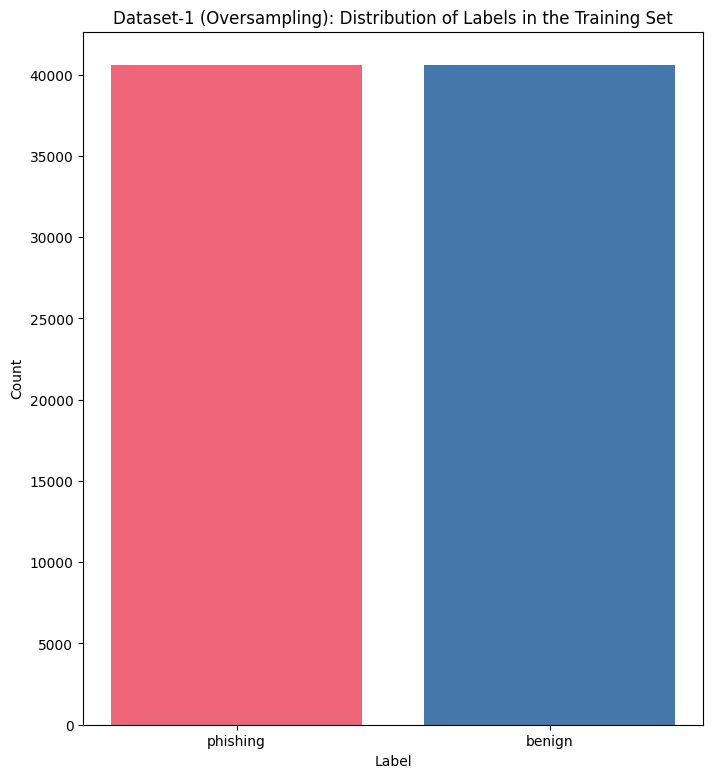

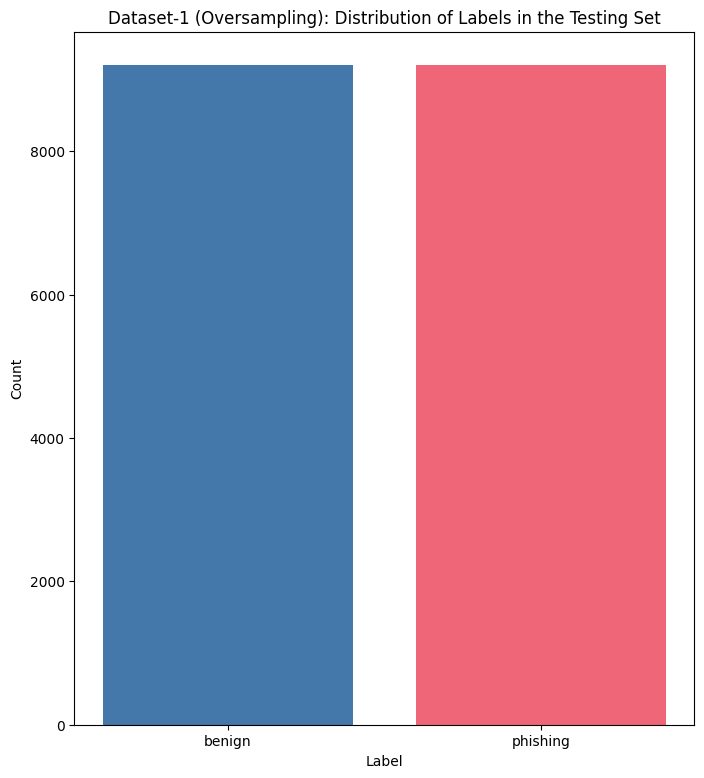

In [ ]:
label_plot1 = plot_label_distribution(y_train_1_over, 'Dataset-1 (Oversampling): Distribution of Labels in the Training Set')
label_plot2 = plot_label_distribution(y_test_1, 'Dataset-1 (Oversampling): Distribution of Labels in the Testing Set')

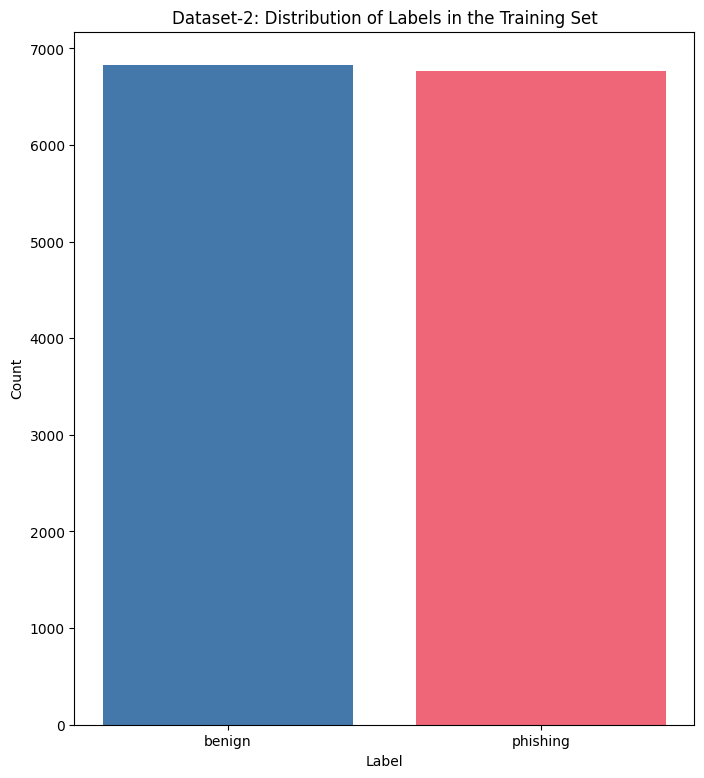

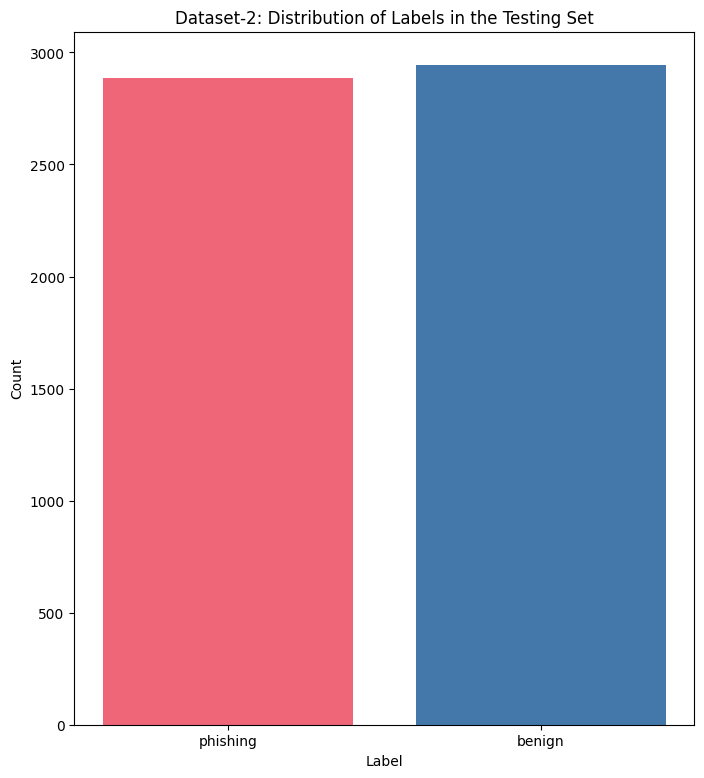

In [ ]:
label_plot3 = plot_label_distribution(y_train_2, 'Dataset-2: Distribution of Labels in the Training Set')
label_plot4 = plot_label_distribution(y_test_2, 'Dataset-2: Distribution of Labels in the Testing Set')

### **ML Model Testing:**

**Training and Evaluating**

In [ ]:
# models = [
#   (LogisticRegression(random_state=42), "Logistic Regression"),
#   (DecisionTreeClassifier(random_state=42), "Decision Tree"),
#   (RandomForestClassifier(random_state=42), "Random Forest"),
#   (GaussianNB(), "Naive Bayes"),
#   (GradientBoostingClassifier(random_state=42), "Gradient Boosting Machine"),
#   (XGBClassifier(use_label_encoder=False, random_state=42), "XGBoost"),
#   (ExplainableBoostingClassifier(random_state=42), "Explainable Boosting Machine"),
#   (svm.SVC(), "SVM")
# ]

# metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# model_name_1 = []
# metrics_1 = []
# model_name_2 = []
# metrics_2 = []
# model_name_3 = []
# metrics_3 = []
# model_name_4 = []
# metrics_4 = []

# print(f"Dataset 1 (Oversampling):\n")
# for model, name in models:
#   metric = train_and_evaluate_model(model, X_train_1_over, y_train_1_over, X_test_1, y_test_1, name)
#   model_name_1.append(name)
#   metrics_1.append(metric)

# print(f"Dataset 1 (Undersampling):\n")
# for model, name in models:
#   metric = train_and_evaluate_model(model, X_train_1_under, y_train_1_under, X_test_1, y_test_1, name)
#   model_name_2.append(name)
#   metrics_2.append(metric)

# print(f"Dataset 1 (Over-Undersampling):\n")
# for model, name in models:
#   metric = train_and_evaluate_model(model, X_train_1_overunder, y_train_1_overunder, X_test_1, y_test_1, name)
#   model_name_3.append(name)
#   metrics_3.append(metric)

# print(f"Dataset 2:\n")
# for model, name in models:
#   metric = train_and_evaluate_model(model, X_train_2, y_train_2, X_test_2, y_test_2, name)
#   model_name_4.append(name)
#   metrics_4.append(metric)

**Comparison of Results**

In [ ]:
# plot_metrics(metrics_1, metric_names, model_name_1, 'Dataset-1 (Oversampling): Comparison of Machine Learning Models')

In [ ]:
# plot_metrics(metrics_2, metric_names, model_name_2, 'Dataset-1 (Undersampling): Comparison of Machine Learning Models')

In [ ]:
# plot_metrics(metrics_3, metric_names, model_name_3, 'Dataset-1 (Over-Undersampling): Comparison of Machine Learning Models')

In [ ]:
# plot_metrics(metrics_4, metric_names, model_name_4, 'Dataset-2: Comparison of Machine Learning Models')

As seen by the graphs, **Oversampling** & **XGBoost** has the highest Accuracy, Precision, Recall, and F1 Score. Thus, it will be the sampling method and model used going forward.

### **Define Full, Unique, and Common Features & Compare:**

In [ ]:
for i, feat in enumerate(X_train_1_over, 1):
  print(f"{i}. {feat}")

1. qty_dot_url
2. qty_hyphen_url
3. qty_underline_url
4. qty_slash_url
5. qty_questionmark_url
6. qty_equal_url
7. qty_at_url
8. qty_and_url
9. qty_exclamation_url
10. qty_space_url
11. qty_tilde_url
12. qty_comma_url
13. qty_plus_url
14. qty_asterisk_url
15. qty_hashtag_url
16. qty_dollar_url
17. qty_percent_url
18. qty_tld_url
19. length_url
20. qty_dot_domain
21. qty_hyphen_domain
22. qty_underline_domain
23. qty_at_domain
24. qty_vowels_domain
25. domain_length
26. domain_in_ip
27. server_client_domain
28. qty_dot_directory
29. qty_hyphen_directory
30. qty_underline_directory
31. qty_slash_directory
32. qty_questionmark_directory
33. qty_equal_directory
34. qty_at_directory
35. qty_and_directory
36. qty_exclamation_directory
37. qty_space_directory
38. qty_tilde_directory
39. qty_comma_directory
40. qty_plus_directory
41. qty_asterisk_directory
42. qty_hashtag_directory
43. qty_dollar_directory
44. qty_percent_directory
45. directory_length
46. qty_dot_file
47. qty_hyphen_file
48. 

In [ ]:
for i, feat in enumerate(X_train_2, 1):
  print(f"{i}. {feat}")

1. url_length
2. hostname_length
3. ip
4. total_of.
5. total_of-
6. total_of@
7. total_of?
8. total_of&
9. total_of=
10. total_of_
11. total_of~
12. total_of%
13. total_of/
14. total_of*
15. total_of:
16. total_of,
17. total_of;
18. total_of$
19. total_of_www
20. total_of_com
21. total_of_http_in_path
22. https_token
23. ratio_digits_url
24. ratio_digits_host
25. punycode
26. port
27. tld_in_path
28. tld_in_subdomain
29. abnormal_subdomain
30. nb_subdomains
31. prefix_suffix
32. random_domain
33. shortening_service
34. path_extension
35. nb_redirection
36. nb_external_redirection
37. length_words_raw
38. char_repeat
39. shortest_words_raw
40. shortest_word_host
41. shortest_word_path
42. longest_words_raw
43. longest_word_host
44. longest_word_path
45. avg_words_raw
46. avg_word_host
47. avg_word_path
48. phish_hints
49. domain_in_brand
50. brand_in_subdomain
51. brand_in_path
52. suspecious_tld
53. statistical_report
54. nb_hyperlinks
55. ratio_intHyperlinks
56. ratio_extHyperlinks
57

In [ ]:
# Get the feature lists for both datasets
features_dataset_1 = X_test_1.columns.tolist()
features_dataset_2 = X_test_2.columns.tolist()

# Define a dictionary where the keys are the feature names in Dataset 1
# and the values are the corresponding feature names in Dataset 2
feature_pairs = {
  "qty_dot_url": "total_of.",
  "qty_hyphen_url": "total_of-",
  "qty_underline_url": "total_of_",
  "qty_slash_url": "total_of/",
  "qty_questionmark_url": "total_of?",
  "qty_equal_url": "total_of=",
  "qty_at_url": "total_of@",
  "qty_and_url": "total_of&",
  "qty_tilde_url": "total_of~",
  "qty_comma_url": "total_of,",
  "qty_asterisk_url": "total_of*",
  "qty_percent_url": "total_of%",
  "qty_dollar_url": "total_of$",
  "url_google_index": "google_index",
  "tld_present_params": "tld_in_path",
  "qty_redirects": "nb_redirection",
  "length_url": "url_length",
  "url_shortened": "shortening_service",
  "domain_length": "hostname_length",
  "domain_in_ip": "ip"
}

# Initialize lists to store the similar and unique features
similar_features = []
unique_features_1 = []
unique_features_2 = []
full_features_1 = []
full_features_2 = []

# Print the similar features of both datasets
print("Similar features:")
for i, (feature_1, feature_2) in enumerate(feature_pairs.items(), 1):
    print(f"{i}. {feature_1} (Dataset 1) - {feature_2} (Dataset 2)")
    similar_features.append((feature_1, feature_2))

# Print the unique features for each dataset
print("\nUnique features in Dataset 1:")
for feat in features_dataset_1:
    if feat not in feature_pairs.keys():
        print(f"{len(unique_features_1) + 1}. {feat}")
        unique_features_1.append(feat)

print("\nUnique features in Dataset 2:")
for feat in features_dataset_2:
    if feat not in feature_pairs.values():
        print(f"{len(unique_features_2) + 1}. {feat}")
        unique_features_2.append(feat)

# Add the similar features to the full features list for each dataset
for feature_1, feature_2 in feature_pairs.items():
    if feature_1 in features_dataset_1 and feature_2 in features_dataset_2:
        full_features_1.append(feature_1)
        full_features_2.append(feature_1)  # Use Dataset 1's naming scheme

# Add the unique features to the full features list for each dataset
for feat in features_dataset_1:
    if feat not in feature_pairs.keys():
        full_features_1.append(feat)

for feat in features_dataset_2:
    if feat not in feature_pairs.values():
        full_features_2.append(feat)  # Keep Dataset 2's unique naming scheme

# Print the full features for both datasets
print("\nFull features in Dataset 1:")
for i, feature in enumerate(full_features_1, 1):
    print(f"{i}. {feature}")

print("\nFull features in Dataset 2:")
for i, feature in enumerate(full_features_2, 1):
    print(f"{i}. {feature}")

# Print the lists of similar and unique features
print("\nSimilar features:", similar_features)
print("\nUnique features in Dataset 1:", unique_features_1)
print("Unique features in Dataset 2:", unique_features_2)
print("\nFull features in Dataset 1:", full_features_1)
print("Full features in Dataset 2:", full_features_2)

Similar features:
1. qty_dot_url (Dataset 1) - total_of. (Dataset 2)
2. qty_hyphen_url (Dataset 1) - total_of- (Dataset 2)
3. qty_underline_url (Dataset 1) - total_of_ (Dataset 2)
4. qty_slash_url (Dataset 1) - total_of/ (Dataset 2)
5. qty_questionmark_url (Dataset 1) - total_of? (Dataset 2)
6. qty_equal_url (Dataset 1) - total_of= (Dataset 2)
7. qty_at_url (Dataset 1) - total_of@ (Dataset 2)
8. qty_and_url (Dataset 1) - total_of& (Dataset 2)
9. qty_tilde_url (Dataset 1) - total_of~ (Dataset 2)
10. qty_comma_url (Dataset 1) - total_of, (Dataset 2)
11. qty_asterisk_url (Dataset 1) - total_of* (Dataset 2)
12. qty_percent_url (Dataset 1) - total_of% (Dataset 2)
13. qty_dollar_url (Dataset 1) - total_of$ (Dataset 2)
14. url_google_index (Dataset 1) - google_index (Dataset 2)
15. tld_present_params (Dataset 1) - tld_in_path (Dataset 2)
16. qty_redirects (Dataset 1) - nb_redirection (Dataset 2)
17. length_url (Dataset 1) - url_length (Dataset 2)
18. url_shortened (Dataset 1) - shortening_ser

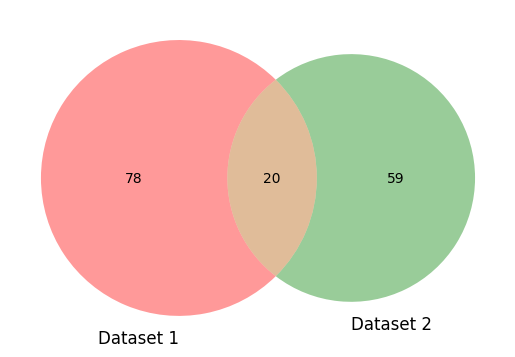

In [ ]:
venn2([set(unique_features_1 + similar_features), set(unique_features_2 + similar_features)], set_labels = ('Dataset 1', 'Dataset 2'))
plt.show()

### **Setup Full, Unique, and Common Features:**

In [ ]:
# Create a reverse mapping dictionary
reverse_feature_pairs = {v: k for k, v in feature_pairs.items()}

# Create a copy of the Dataset 2 and rename the shared features to match Dataset 1's naming scheme
X_train_2_alt = X_train_2.copy()
X_train_2_alt.rename(columns=reverse_feature_pairs, inplace=True)

X_test_2_alt = X_test_2.copy()
X_test_2_alt.rename(columns=reverse_feature_pairs, inplace=True)

**Full Features**

In [ ]:
X_train_1_over_full = X_train_1_over[full_features_1]
X_test_1_full = X_test_1[full_features_1]

In [ ]:
X_train_2_full = X_train_2_alt[full_features_2]
X_test_2_full = X_test_2_alt[full_features_2]

**Unique and Common Features**

In [ ]:
X_train_1_over_unique = X_train_1_over[unique_features_1]
X_test_1_unique = X_test_1[unique_features_1]

In [ ]:
X_train_1_over_common = X_train_1_over[[feature[0] for feature in similar_features]]
X_test_1_common = X_test_1[[feature[0] for feature in similar_features]]

In [ ]:
X_train_2_unique = X_train_2[unique_features_2]
X_test_2_unique = X_test_2[unique_features_2]

In [ ]:
X_train_2_common = X_train_2[[feature[1] for feature in similar_features]]
X_test_2_common = X_test_2[[feature[1] for feature in similar_features]]

### **Merge Datasets:**

In [ ]:
# Extract the common features for each dataset
common_features_df1 = [feature[0] for feature in similar_features]
common_features_df2 = [feature[1] for feature in similar_features]

In [ ]:
# Select only the common features from each dataframe
X_train_1_over_setup = X_train_1_over_sampled[common_features_df1]
X_test_1_setup = X_test_1[common_features_df1]

X_train_2_setup = X_train_2[common_features_df2]
X_test_2_setup = X_test_2[common_features_df2]

In [ ]:
# Create a dictionary mapping df2 column names to df1 column names
column_mapping = {feature[1]: feature[0] for feature in similar_features}

# Rename the columns
X_train_2_setup = X_train_2_setup.rename(columns=column_mapping)
X_test_2_setup = X_test_2_setup.rename(columns=column_mapping)

In [ ]:
X_train_12_over_merge = pd.concat([X_train_1_over_setup, X_train_2_setup])
y_train_12_over_merge = pd.concat([y_train_1_over_sampled, y_train_2])

X_test_12_merge = pd.concat([X_test_1_setup, X_test_2_setup])
y_test_12_merge = pd.concat([y_test_1, y_test_2])

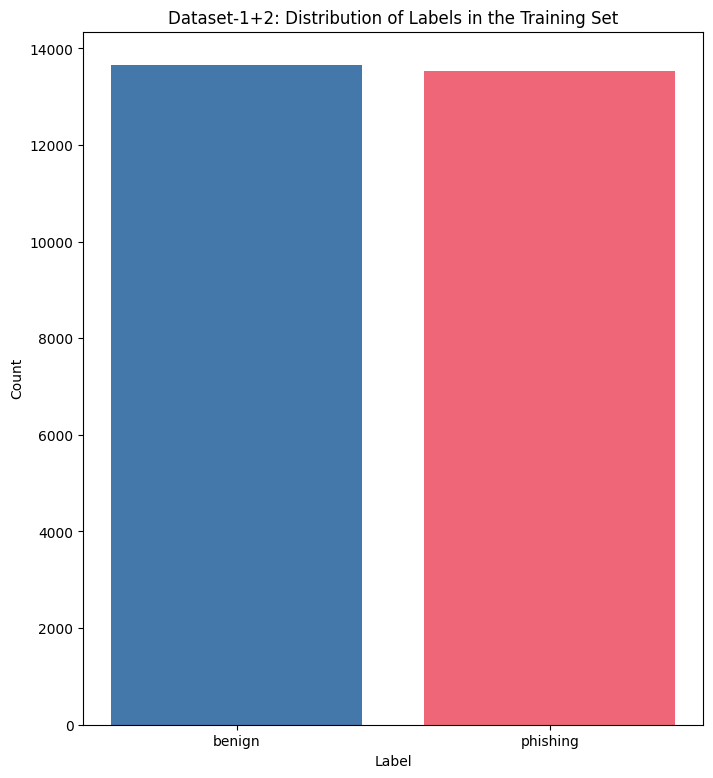

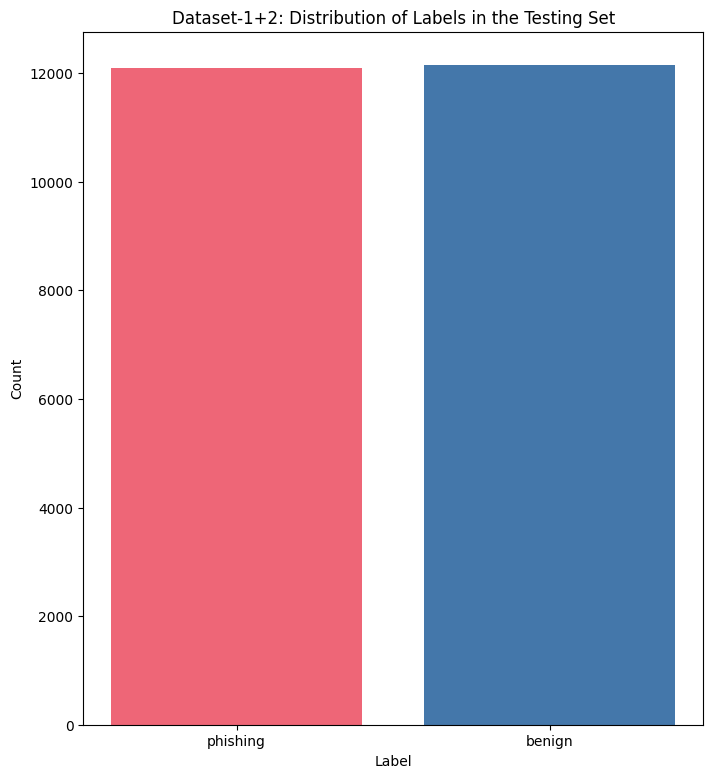

In [ ]:
label_plot5 = plot_label_distribution(y_train_12_over_merge, 'Dataset-1+2: Distribution of Labels in the Training Set')
label_plot6 = plot_label_distribution(y_test_12_merge, 'Dataset-1+2: Distribution of Labels in the Testing Set')

### **Feature Importance Setup:**

**Setup Variables**

In [ ]:
X_train_1_over_full, X_test_1_over_full = X_train_1_over_full, X_test_1_full
X_train_2_over_full, X_test_2_over_full = X_train_2_full, X_test_2_full

In [ ]:
X_train_1_over_unique, X_test_1_over_unique = X_train_1_over_unique, X_test_1_unique
X_train_1_over_common, X_test_1_over_common = X_train_1_over_common, X_test_1_common

In [ ]:
X_train_2_unique, X_test_2_unique = X_train_2_unique, X_test_2_unique
X_train_2_common, X_test_2_common = X_train_2_common, X_test_2_common

In [ ]:
X_train_12_over_merge, X_test_12_over_merge = X_train_12_over_merge, X_test_12_merge

**Extract Similar Features and Rename Columns**

In [ ]:
# Extract the similar features from the datasets
X_train_1_over_similar = X_train_1_over_common[[feature[0] for feature in similar_features if feature[0] in X_train_1_over_common.columns]].copy()
X_test_1_over_similar = X_test_1_over_common[[feature[0] for feature in similar_features if feature[0] in X_test_1_over_common.columns]].copy()

X_train_2_similar = X_train_2_common[[feature[1] for feature in similar_features if feature[1] in X_train_2_common.columns]].copy()
X_test_2_similar = X_test_2_common[[feature[1] for feature in similar_features if feature[1] in X_test_2_common.columns]].copy()

# Create a dictionary to map the new column names to the old ones
rename_dict = {feature[1]: feature[0] for feature in similar_features if feature[1] in X_train_2_similar.columns and feature[0] in X_train_1_over_similar.columns}

# Rename the columns in Dataset 2 to match those in Dataset 1
X_train_2_similar.rename(columns=rename_dict, inplace=True)
X_test_2_similar.rename(columns=rename_dict, inplace=True)

**Get Common Feature Columns from Datasets**

In [ ]:
similar_columns = list(set(X_train_1_over_similar.columns) & set(X_train_2_similar.columns) & set(X_train_12_over_merge.columns))

In [ ]:
for i, col in enumerate(similar_columns, 1):
  print(f"{i}. {col}")

1. qty_dollar_url
2. url_google_index
3. domain_in_ip
4. url_shortened
5. qty_comma_url
6. length_url
7. qty_dot_url
8. tld_present_params
9. qty_tilde_url
10. domain_length
11. qty_at_url
12. qty_redirects
13. qty_hyphen_url
14. qty_asterisk_url
15. qty_questionmark_url
16. qty_slash_url
17. qty_percent_url
18. qty_and_url
19. qty_equal_url
20. qty_underline_url


**Select Common Columns for Equivalency**

In [ ]:
X_train_1_over_similar = X_train_1_over_similar[similar_columns]
X_test_1_over_similar = X_test_1_over_similar[similar_columns]

X_train_2_similar = X_train_2_similar[similar_columns]
X_test_2_similar = X_test_2_similar[similar_columns]

X_train_12_over_merge = X_train_12_over_merge[similar_columns]
X_test_12_over_merge = X_test_12_over_merge[similar_columns]

### **Feature Importance Using SHAP**

**1. Train on Dataset-1 (Oversampled) with Full Features, Test on Dataset-1 (Oversampled)**

In [ ]:
# Dataset 1 (Oversampling)
model_1 = XGBClassifier(use_label_encoder=False, random_state=42)
model_1.fit(X_train_1_over_full, y_train_1_over)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
predicted_1 = model_1.predict(X_test_1_over_full)
print(classification_report(y_test_1, predicted_1, target_names=['legitimate','phishing']))

              precision    recall  f1-score   support

  legitimate       0.97      0.97      0.97      9209
    phishing       0.97      0.97      0.97      9209

    accuracy                           0.97     18418
   macro avg       0.97      0.97      0.97     18418
weighted avg       0.97      0.97      0.97     18418



In [ ]:
# Initialize the SHAP explainer
explainer_1 = shap.Explainer(model_1, X_train_1_over_full)

# Calculate SHAP values
shap_values_1 = explainer_1(X_test_1_over_full)

100%|===================| 18354/18418 [01:25<00:00]       

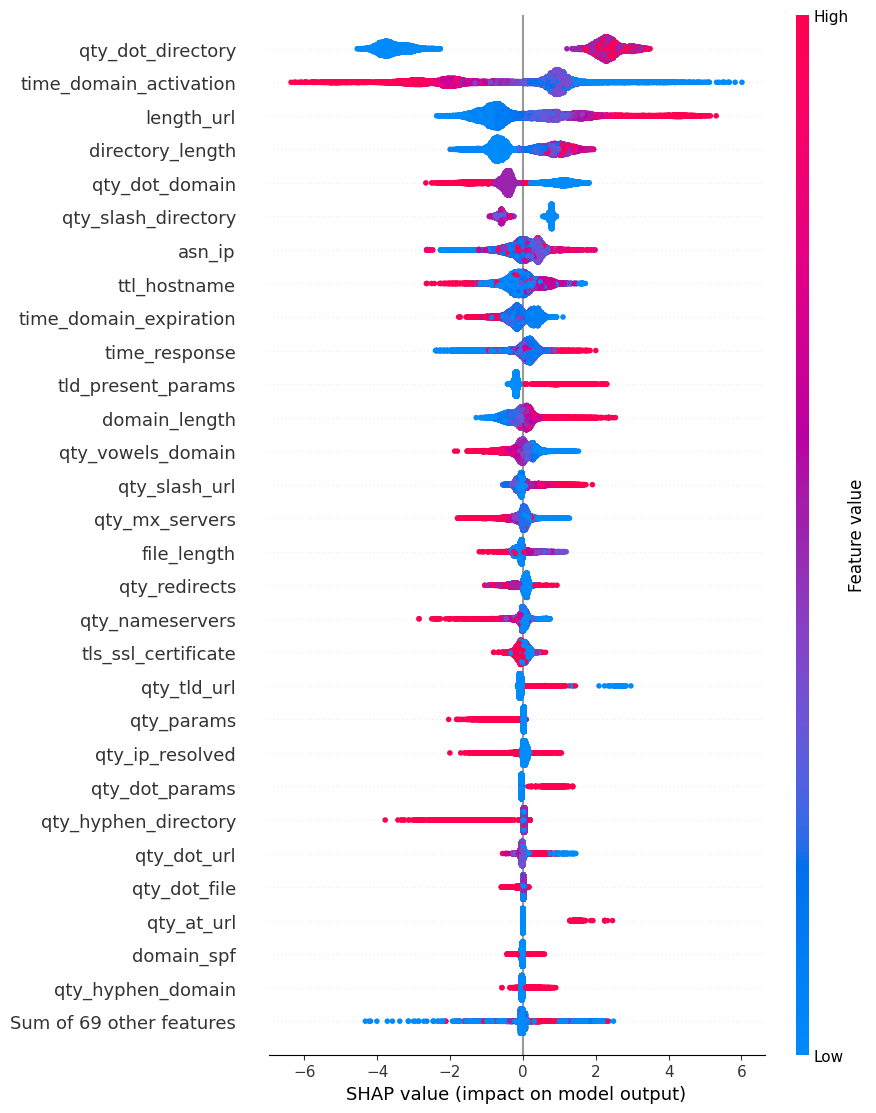

In [ ]:
# Train on Dataset-1 (Oversampled), Test on Dataset-1
shap.plots.beeswarm(shap_values_1, max_display=30)

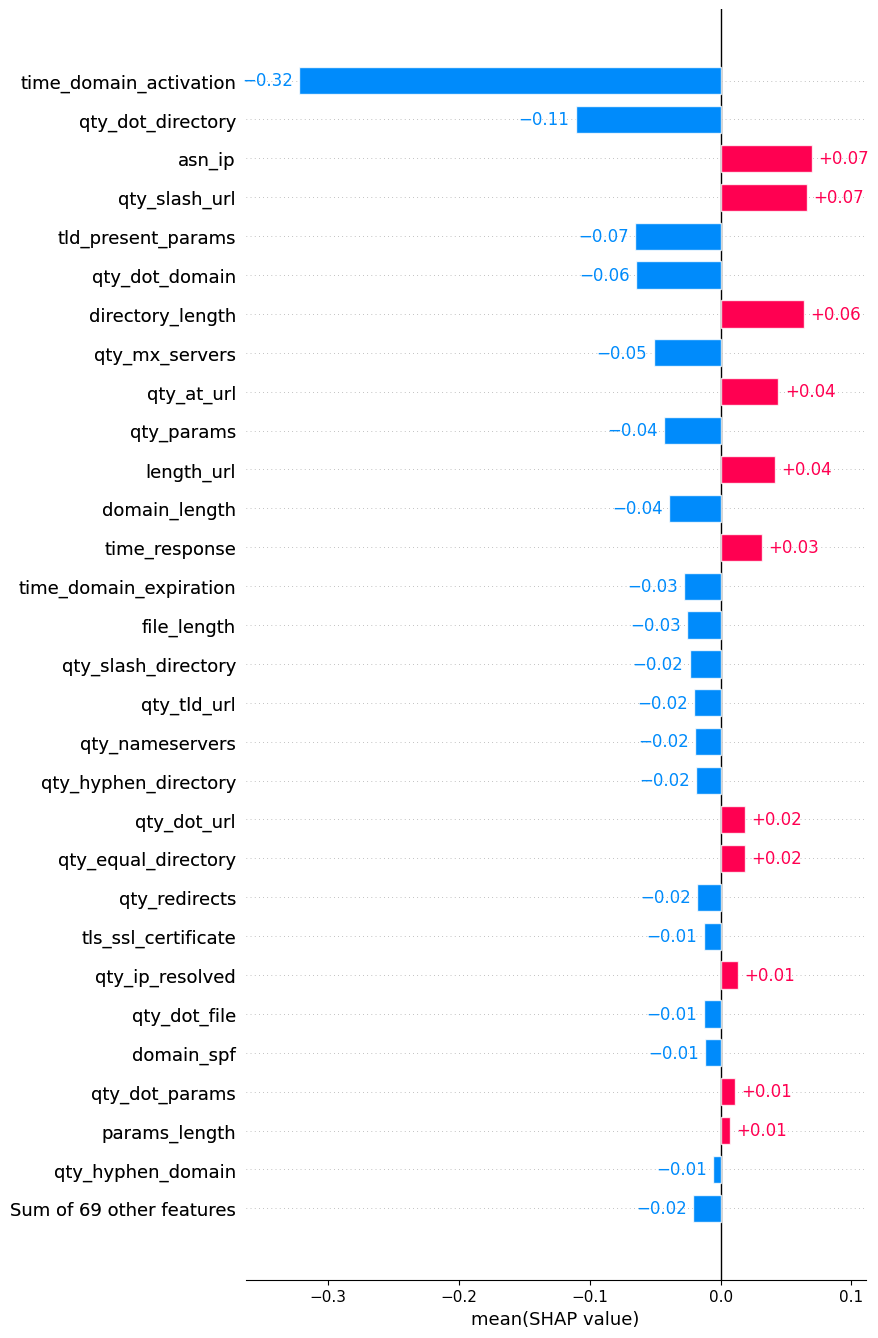

In [ ]:
shap.plots.bar(shap_values_1.mean(0), max_display=30)

**2. Train on Dataset-2 with Full Features, Test on Dataset-2**

In [ ]:
# Dataset 2
model_2 = XGBClassifier(use_label_encoder=False, random_state=42)
model_2.fit(X_train_2_full, y_train_2)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
predicted_2 = model_2.predict(X_test_2_full)
print(classification_report(y_test_2, predicted_2, target_names=['legitimate','phishing']))

              precision    recall  f1-score   support

  legitimate       0.99      0.99      0.99      2885
    phishing       0.99      0.99      0.99      2945

    accuracy                           0.99      5830
   macro avg       0.99      0.99      0.99      5830
weighted avg       0.99      0.99      0.99      5830



In [ ]:
# Initialize the SHAP explainer
explainer_2 = shap.Explainer(model_2, X_train_2_full)

# Calculate SHAP values
shap_values_2 = explainer_2(X_test_2_full)

 99%|===================| 5787/5830 [00:43<00:00]       

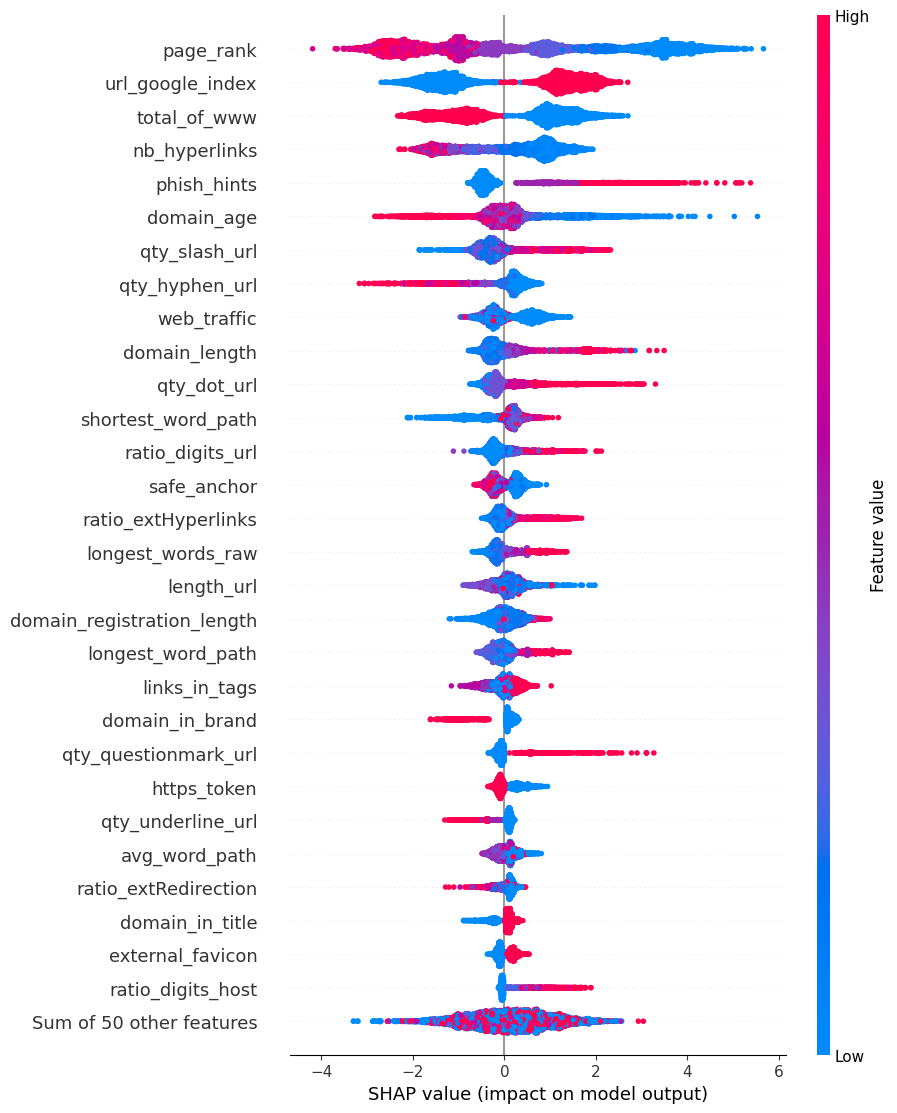

In [ ]:
# Train on Dataset-2, Test on Dataset-2
shap.plots.beeswarm(shap_values_2, max_display=30)

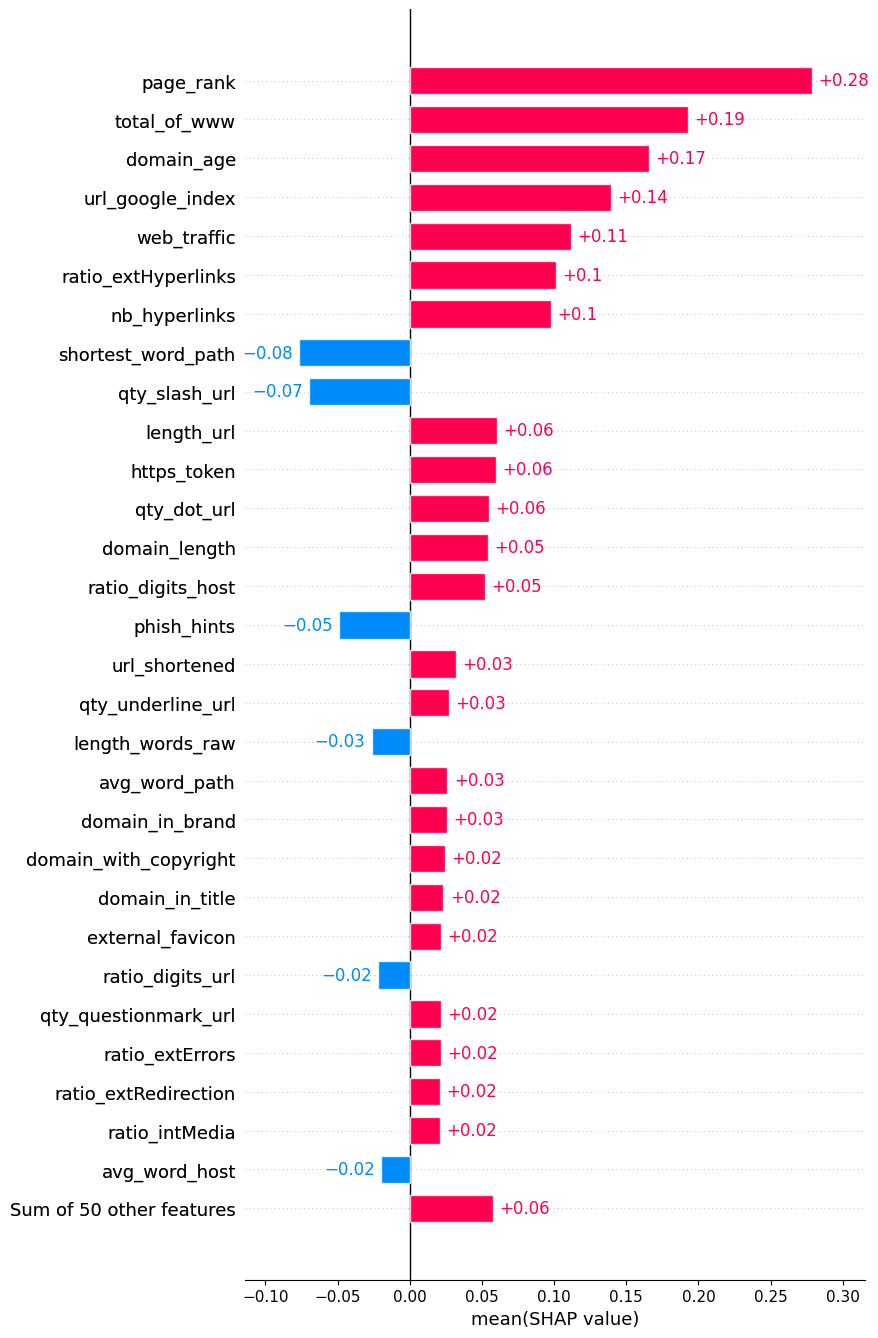

In [ ]:
shap.plots.bar(shap_values_2.mean(0), max_display=30)

**3. Train on Dataset-1 (Oversampled) with Common Features, Test on Dataset-1 (Oversampled)**

In [ ]:
# Dataset 1 (Oversampling)
model_3 = XGBClassifier(use_label_encoder=False, random_state=42)
model_3.fit(X_train_1_over_similar, y_train_1_over)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
predicted_3 = model_3.predict(X_test_1_over_similar)
print(classification_report(y_test_1, predicted_3, target_names=['legitimate','phishing']))

              precision    recall  f1-score   support

  legitimate       0.92      0.92      0.92      9209
    phishing       0.92      0.92      0.92      9209

    accuracy                           0.92     18418
   macro avg       0.92      0.92      0.92     18418
weighted avg       0.92      0.92      0.92     18418



In [ ]:
# Initialize the SHAP explainer
explainer_3 = shap.Explainer(model_3, X_train_1_over_similar)

# Calculate SHAP values
shap_values_3 = explainer_3(X_test_1_over_similar)

 99%|===================| 18198/18418 [01:09<00:00]       

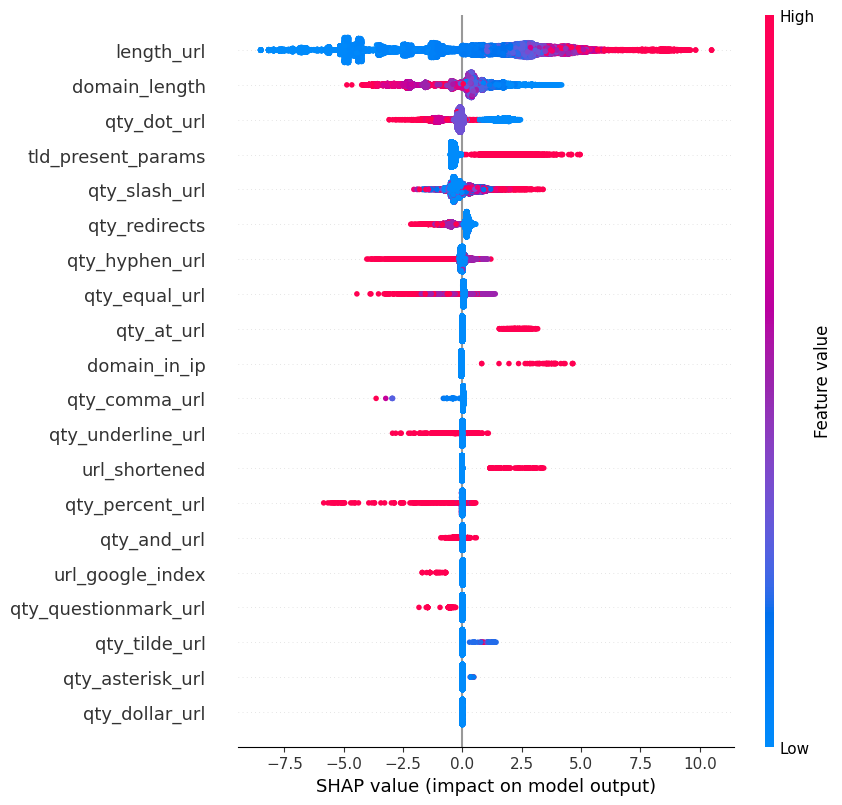

In [ ]:
# Train on Dataset-1 (Oversampled), Test on Dataset-1 (Oversampled)
shap.plots.beeswarm(shap_values_3, max_display=20)

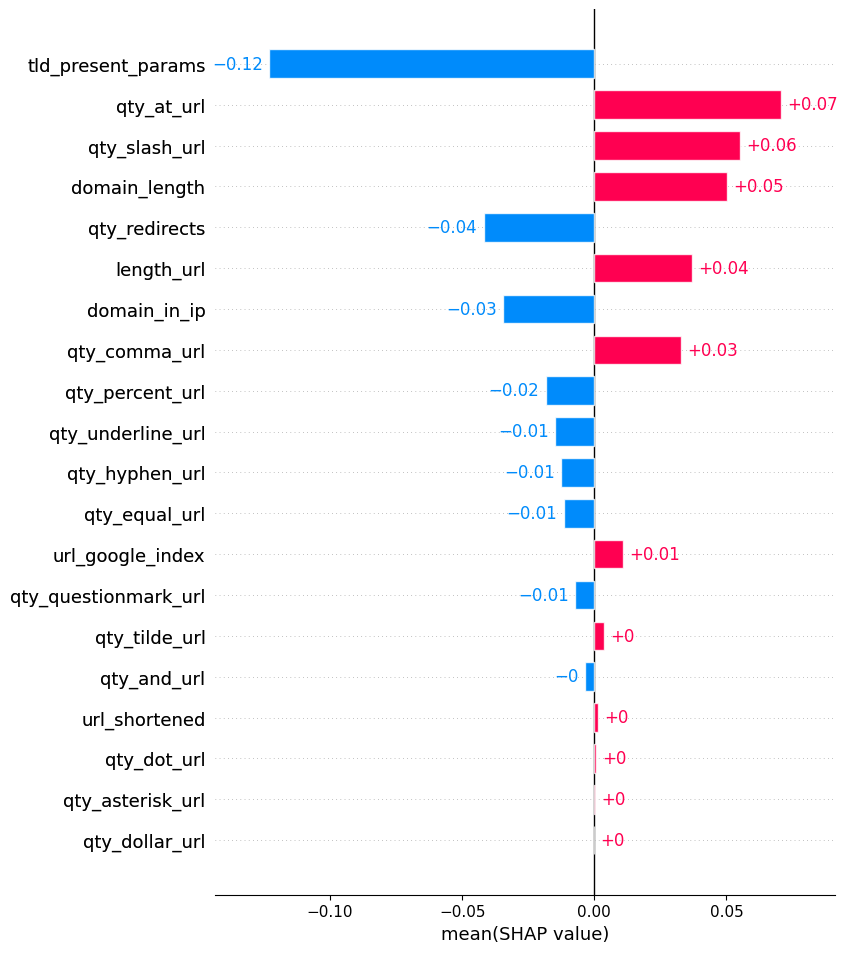

In [ ]:
shap.plots.bar(shap_values_3.mean(0), max_display=20)

**4. Train on Dataset-2 with Common Features, Test on Dataset-2**

In [ ]:
# Dataset 2
model_4 = XGBClassifier(use_label_encoder=False, random_state=42)
model_4.fit(X_train_2_similar, y_train_2)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
predicted_4 = model_4.predict(X_test_2_similar)
print(classification_report(y_test_2, predicted_4, target_names=['legitimate','phishing']))

              precision    recall  f1-score   support

  legitimate       0.93      0.94      0.93      2885
    phishing       0.94      0.93      0.93      2945

    accuracy                           0.93      5830
   macro avg       0.93      0.93      0.93      5830
weighted avg       0.93      0.93      0.93      5830



In [ ]:
# Initialize the SHAP explainer
explainer_4 = shap.Explainer(model_4, X_train_2_similar)

# Calculate SHAP values
shap_values_4 = explainer_4(X_test_2_similar)

 99%|===================| 5746/5830 [00:24<00:00]       

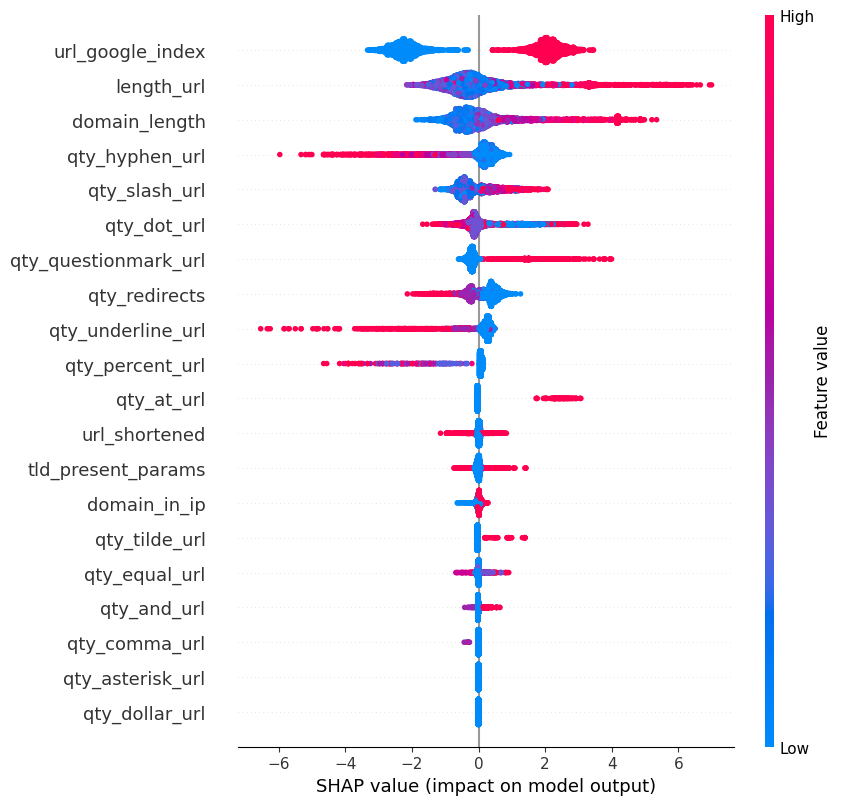

In [ ]:
# Train on Dataset-2, Test on Dataset-2
shap.plots.beeswarm(shap_values_4, max_display=20)

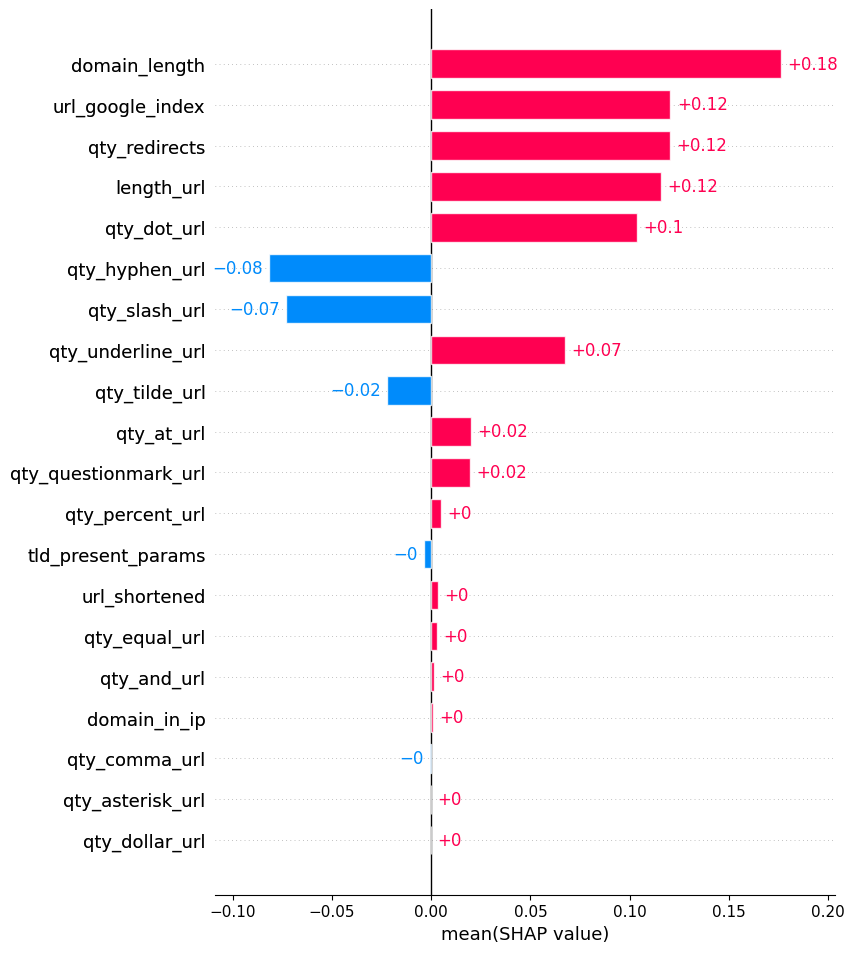

In [ ]:
shap.plots.bar(shap_values_4.mean(0), max_display=20)

**5. Train on Dataset-1 (Oversampled), Test on Dataset-2**

In [ ]:
# Dataset 1 (Oversampling)
model_5 = XGBClassifier(use_label_encoder=False, random_state=42)
model_5.fit(X_train_1_over_similar, y_train_1_over)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
predicted_5 = model_5.predict(X_test_2_similar)
print(classification_report(y_test_2, predicted_5, target_names=['legitimate','phishing']))

              precision    recall  f1-score   support

  legitimate       0.67      0.02      0.04      2885
    phishing       0.51      0.99      0.67      2945

    accuracy                           0.51      5830
   macro avg       0.59      0.51      0.36      5830
weighted avg       0.59      0.51      0.36      5830



In [ ]:
# Initialize the SHAP explainer
explainer_5 = shap.Explainer(model_5, X_train_1_over_similar)

# Calculate SHAP values
shap_values_5 = explainer_5(X_test_2_similar)

 98%|===================| 5695/5830 [00:24<00:00]       

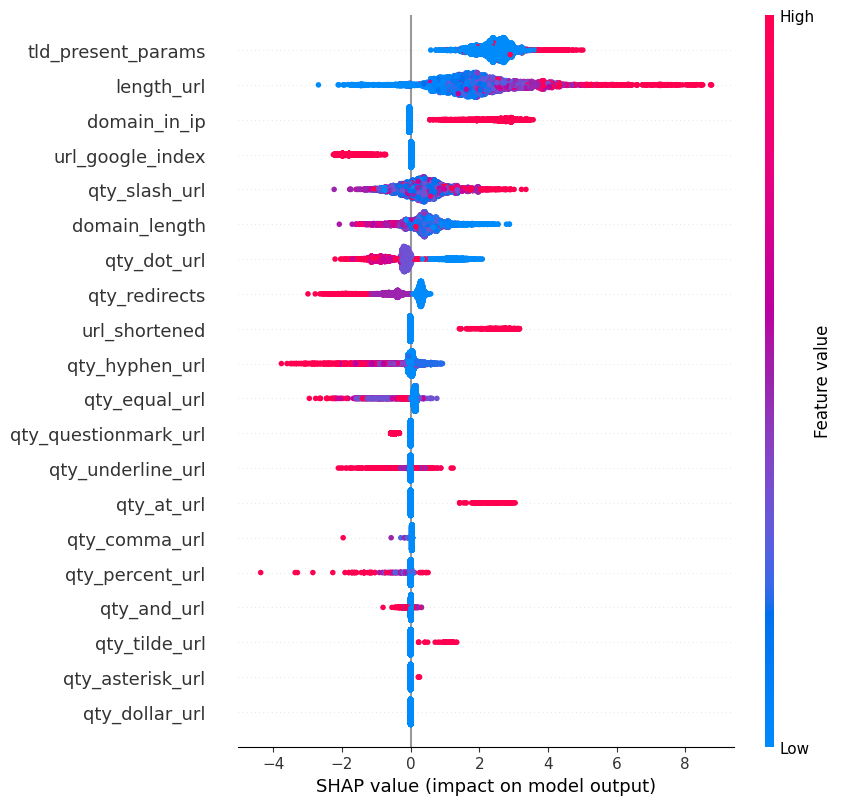

In [ ]:
# Train on Dataset-1 (Oversampled), Test on Dataset-2
shap.plots.beeswarm(shap_values_5, max_display=20)

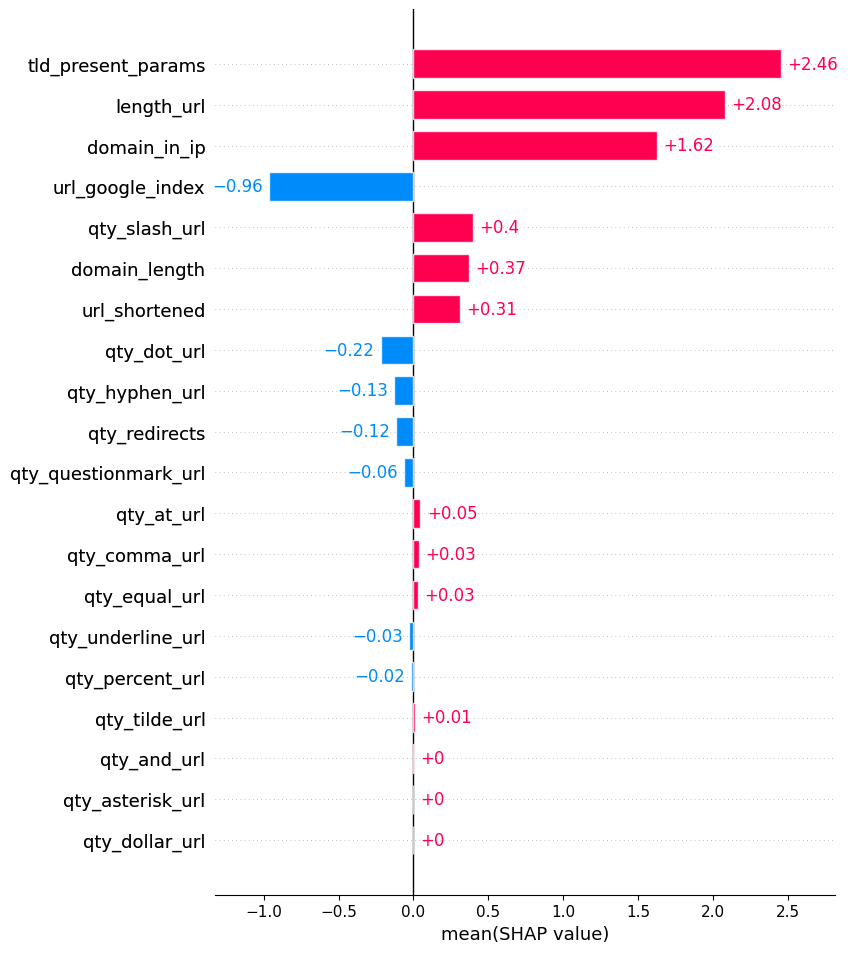

In [ ]:
shap.plots.bar(shap_values_5.mean(0), max_display=20)

**6. Train on Dataset-2, Test on Dataset-1**

In [ ]:
# Dataset 2
model_6 = XGBClassifier(use_label_encoder=False, random_state=42)
model_6.fit(X_train_2_similar, y_train_2)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
predicted_6 = model_6.predict(X_test_1_over_similar)
print(classification_report(y_test_1, predicted_6, target_names=['legitimate','phishing']))

              precision    recall  f1-score   support

  legitimate       0.54      0.97      0.70      9209
    phishing       0.87      0.18      0.30      9209

    accuracy                           0.58     18418
   macro avg       0.70      0.58      0.50     18418
weighted avg       0.70      0.58      0.50     18418



In [ ]:
# Initialize the SHAP explainer
explainer_6 = shap.Explainer(model_6, X_train_2_similar)

# Calculate SHAP values
shap_values_6 = explainer_6(X_test_1_over_similar)

100%|===================| 18341/18418 [01:16<00:00]       

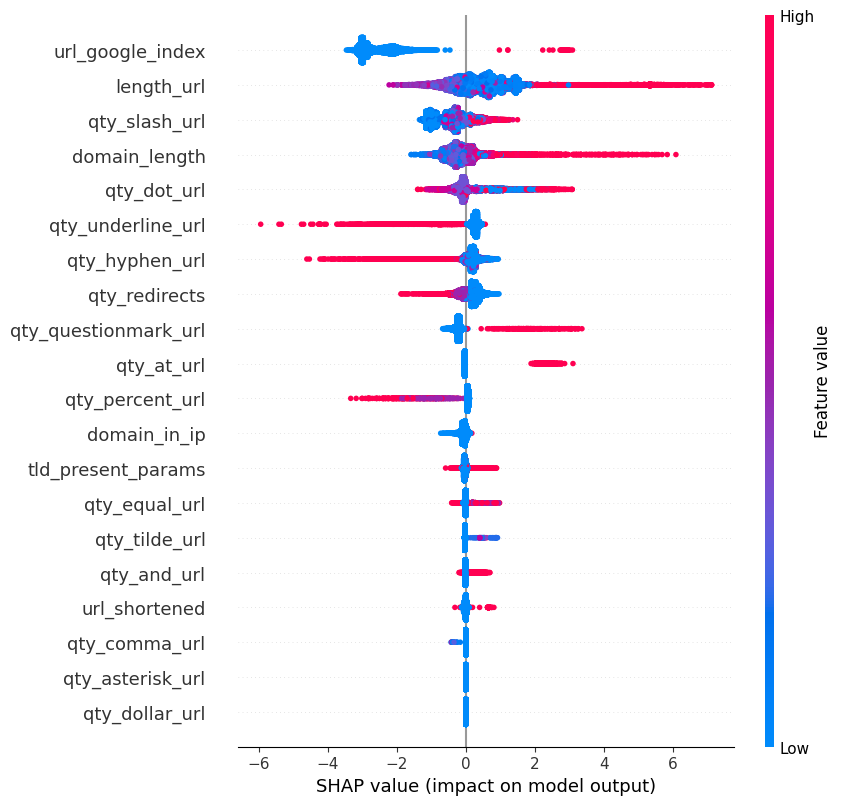

In [ ]:
# Train on Dataset-2, Test on Dataset-1
shap.plots.beeswarm(shap_values_6, max_display=20)

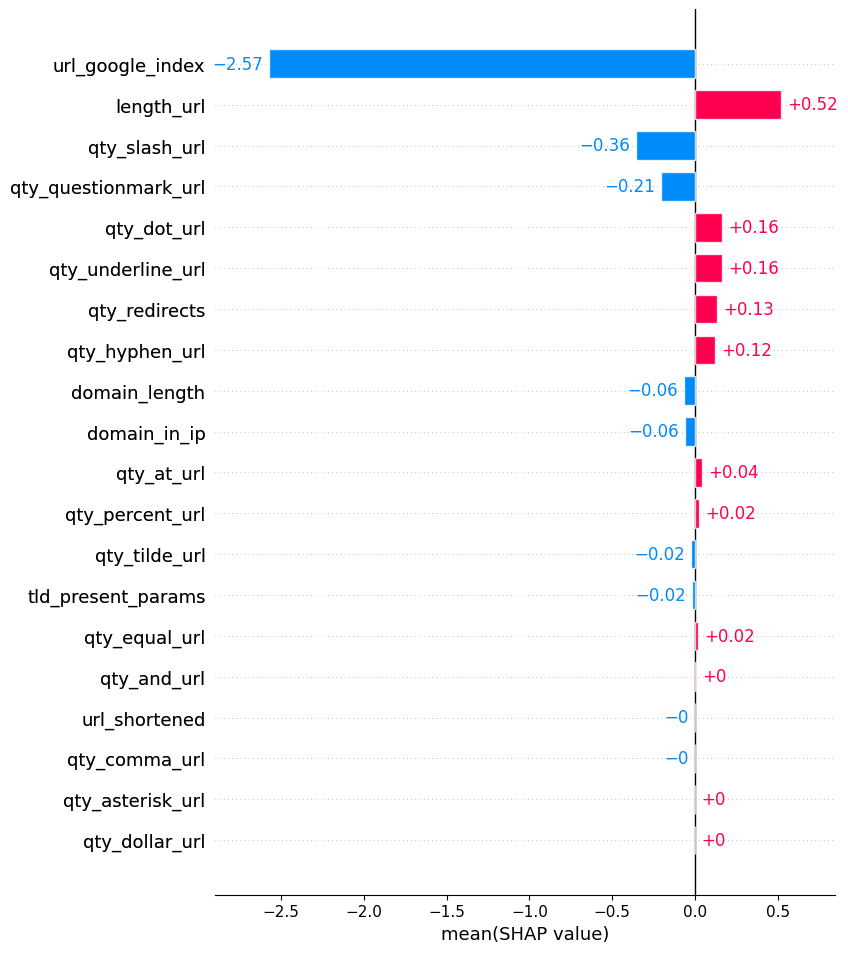

In [ ]:
shap.plots.bar(shap_values_6.mean(0), max_display=20)

**7. Train on Dataset-1+2 (Oversampled), Test on Dataset-1**

In [ ]:
# Dataset 1+2
model_7 = XGBClassifier(use_label_encoder=False, random_state=42)
model_7.fit(X_train_12_over_merge, y_train_12_over_merge)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
predicted_7 = model_7.predict(X_test_1_over_similar)
print(classification_report(y_test_1, predicted_7, target_names=['legitimate','phishing']))

              precision    recall  f1-score   support

  legitimate       0.92      0.92      0.92      9209
    phishing       0.92      0.92      0.92      9209

    accuracy                           0.92     18418
   macro avg       0.92      0.92      0.92     18418
weighted avg       0.92      0.92      0.92     18418



In [ ]:
# Initialize the SHAP explainer
explainer_7 = shap.Explainer(model_7, X_train_12_over_merge)

# Calculate SHAP values
shap_values_7 = explainer_7(X_test_1_over_similar)

100%|===================| 18329/18418 [01:17<00:00]       

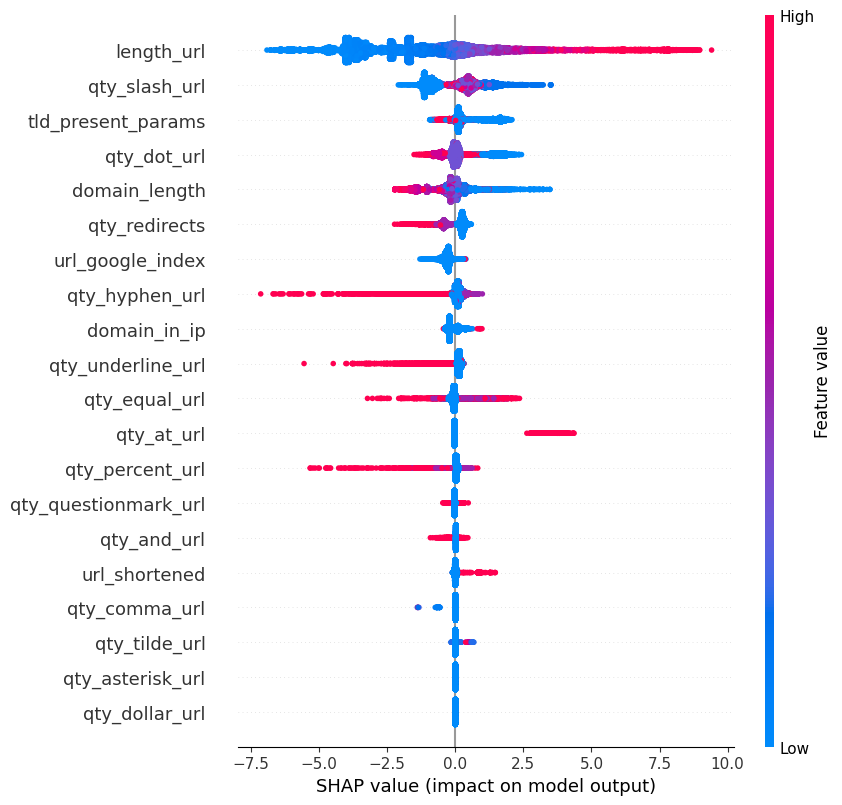

In [ ]:
# Train on Dataset-1+2 (Oversampled), Test on Dataset-1
shap.plots.beeswarm(shap_values_7, max_display=20)

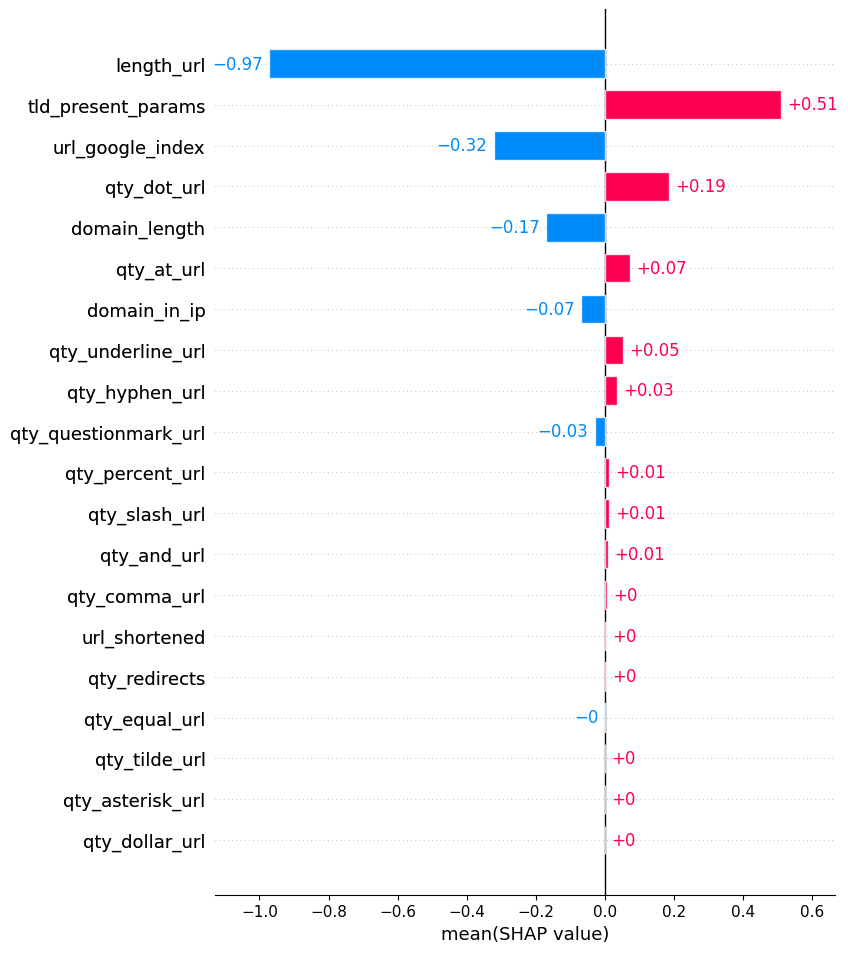

In [ ]:
shap.plots.bar(shap_values_7.mean(0), max_display=20)

**8. Train on Dataset-1+2 (Oversampled), Test on Dataset-2**

In [ ]:
# Dataset 1+2
model_8 = XGBClassifier(use_label_encoder=False, random_state=42)
model_8.fit(X_train_12_over_merge, y_train_12_over_merge)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
predicted_8 = model_8.predict(X_test_2_similar)
print(classification_report(y_test_2, predicted_8, target_names=['legitimate','phishing']))

              precision    recall  f1-score   support

  legitimate       0.92      0.93      0.93      2885
    phishing       0.93      0.92      0.93      2945

    accuracy                           0.93      5830
   macro avg       0.93      0.93      0.93      5830
weighted avg       0.93      0.93      0.93      5830



In [ ]:
# Initialize the SHAP explainer
explainer_8 = shap.Explainer(model_8, X_train_12_over_merge)

# Calculate SHAP values
shap_values_8 = explainer_8(X_test_2_similar)

 96%|=================== | 5617/5830 [00:25<00:00]       

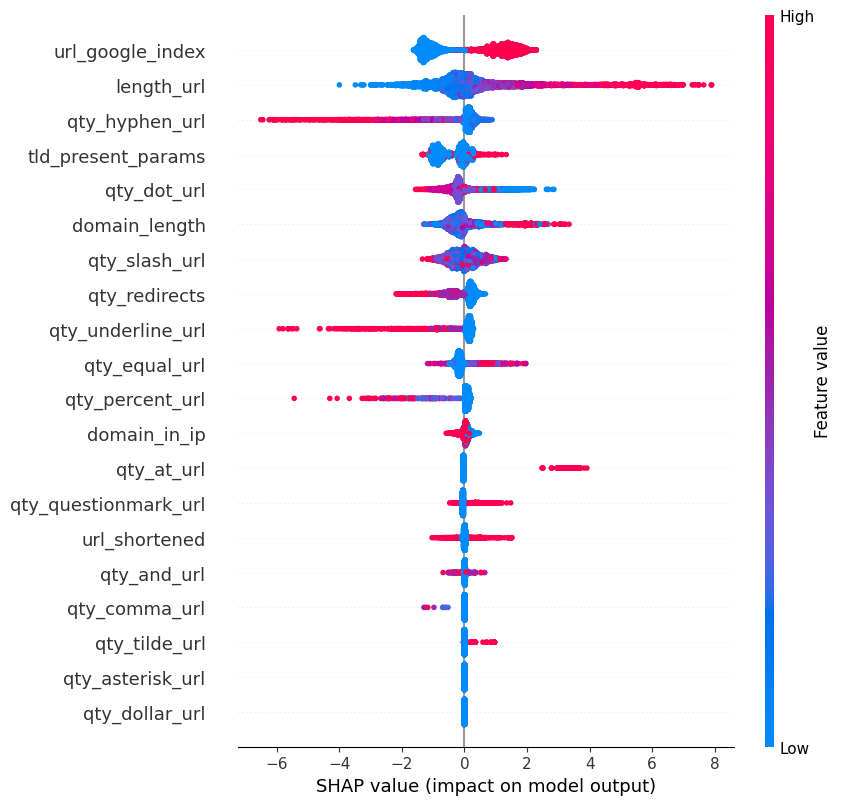

In [ ]:
# Train on Dataset-1+2 (Oversampled), Test on Dataset-2
shap.plots.beeswarm(shap_values_8, max_display=20)

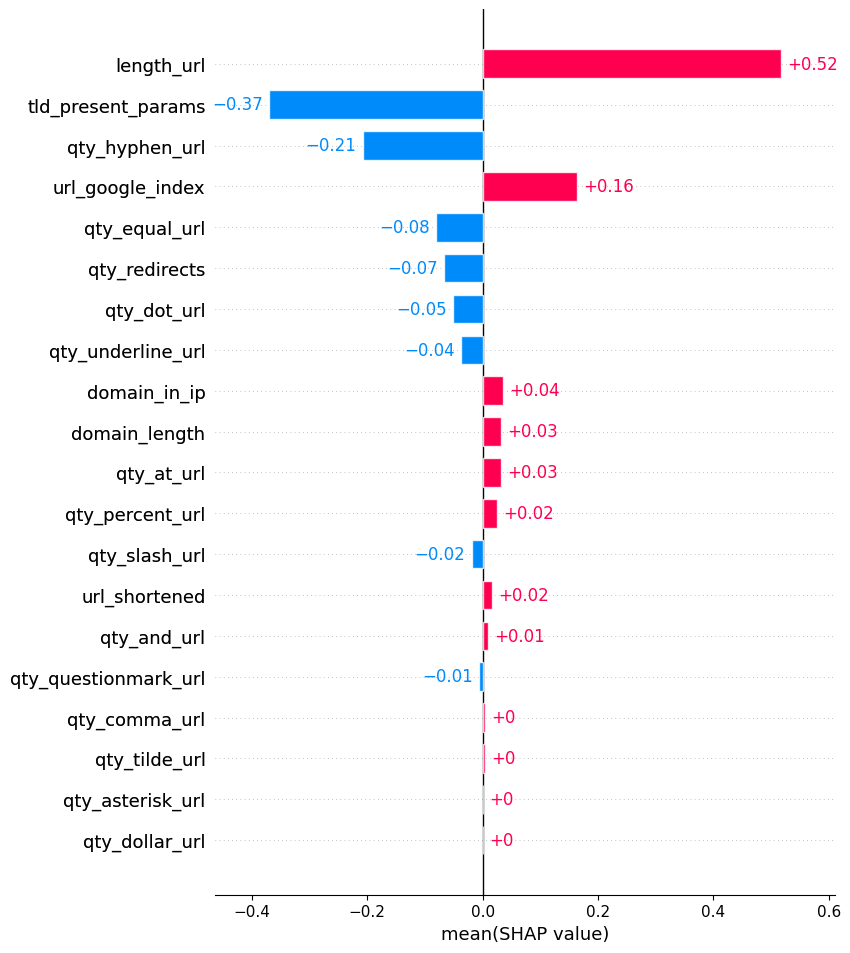

In [ ]:
shap.plots.bar(shap_values_8.mean(0), max_display=20)

**9. Train on Dataset-1+2 (Oversampled), Test on Dataset-1+2**

In [ ]:
# Dataset 1+2
model_9 = XGBClassifier(use_label_encoder=False, random_state=42)
model_9.fit(X_train_12_over_merge, y_train_12_over_merge)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
predicted_9 = model_9.predict(X_test_12_over_merge)
print(classification_report(y_test_12_merge, predicted_9, target_names=['legitimate','phishing']))

              precision    recall  f1-score   support

  legitimate       0.92      0.92      0.92     12094
    phishing       0.92      0.92      0.92     12154

    accuracy                           0.92     24248
   macro avg       0.92      0.92      0.92     24248
weighted avg       0.92      0.92      0.92     24248



In [ ]:
# Initialize the SHAP explainer
explainer_9 = shap.Explainer(model_9, X_train_12_over_merge)

# Calculate SHAP values
shap_values_9 = explainer_9(X_test_12_over_merge)

 99%|===================| 24001/24248 [01:40<00:01]       

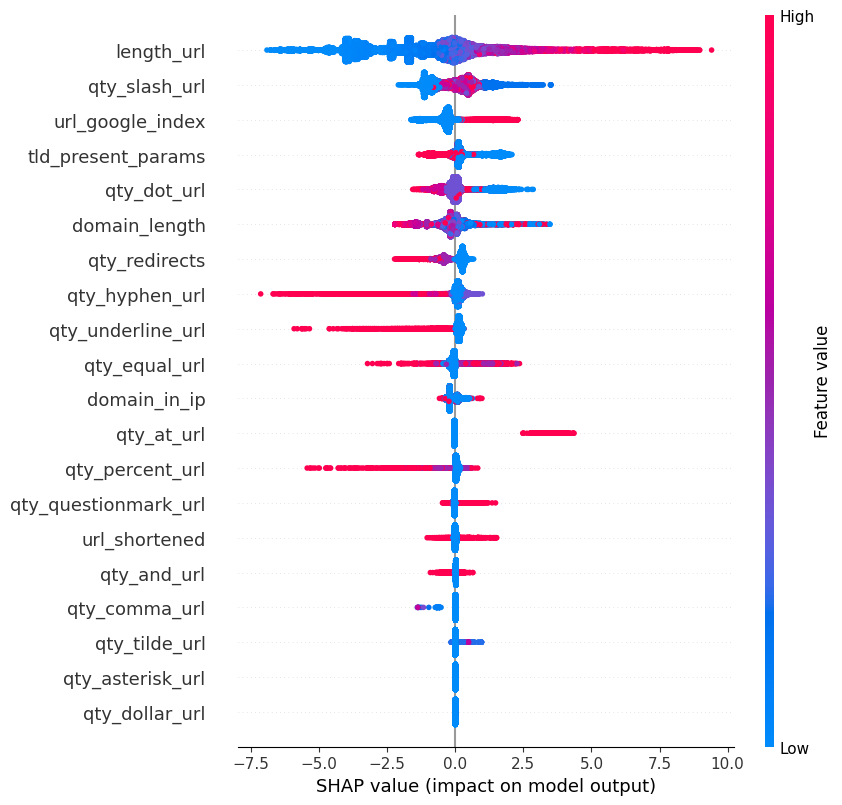

In [ ]:
# Train on Dataset-1+2 (Oversampled), Test on Dataset-1+2
shap.plots.beeswarm(shap_values_9, max_display=20)

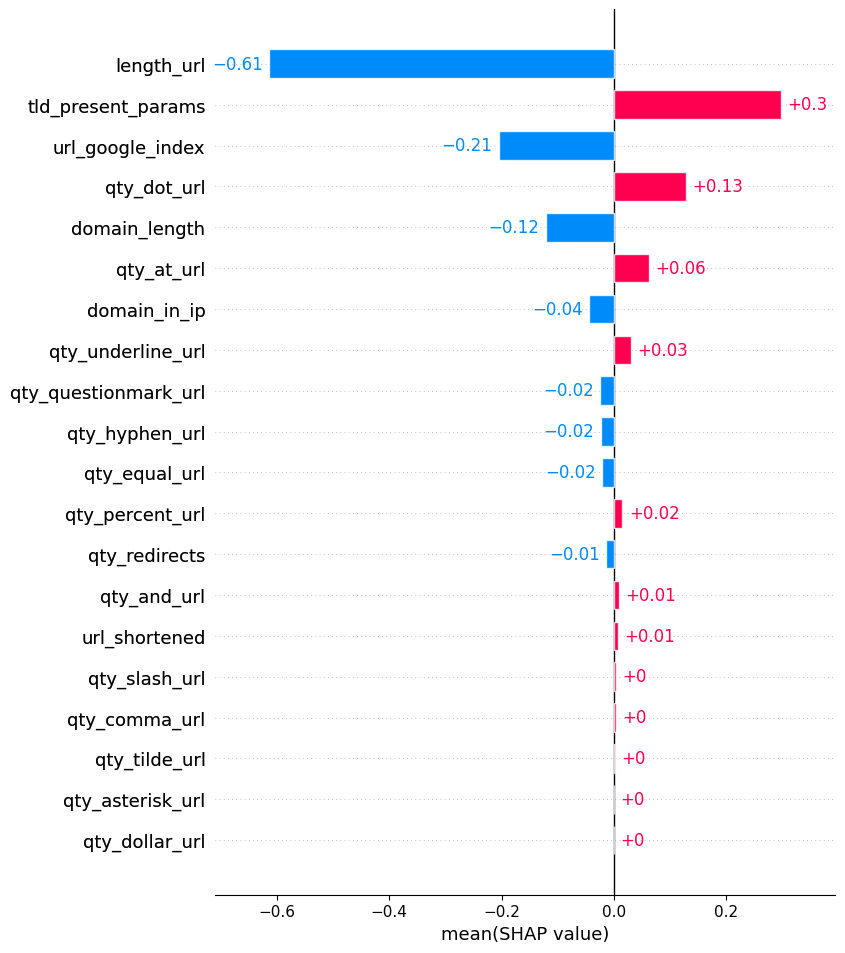

In [ ]:
shap.plots.bar(shap_values_9.mean(0), max_display=20)